In [1]:
import torch
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import timm
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [3]:
# model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5s.pt', force_reload = True)
custom_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp8/weights/best.pt', force_reload = True)
model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to C:\Users\Admin/.cache\torch\hub\master.zip
YOLOv5  2022-6-27 Python-3.8.8 torch-1.9.1+cpu CPU

Fusing layers... 
Model summary: 213 layers, 7255552 parameters, 0 gradients
Adding AutoShape... 
Using cache found in C:\Users\Admin/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\Admin/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


In [4]:
custom_model.names = ['NULL','person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eyeglasses' ,'handbag', 'tie', 
        'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard','tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk' ,'toilet', 'door', 'tv', 'laptop',
         'mouse', 'remote', 'keyboard', 'cell phone','microwave', 'oven', 'toaster', 'sink', 'refrigerator','blender','book', 'clock', 'vase', 'scissors', 'teddy bear','hair drier', 'toothbrush', 'hair brush']

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\Admin/.cache\torch\hub\intel-isl_MiDaS_master


In [66]:
filename = 'yolov5/NUS_Cycle.jpeg'

In [67]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (pad): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel

In [68]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [69]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

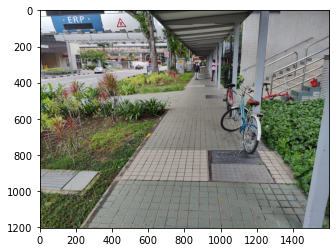

In [70]:
plt.imshow(img)

In [71]:
img.shape

(1203, 1600, 3)

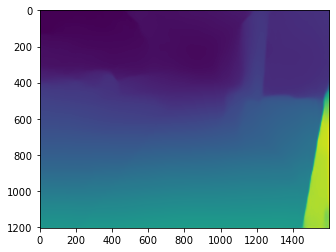

In [72]:
plt.imshow(output)

In [73]:
# height = output.shape[0]
# width = output.shape[1]

# left_side = output[:,:width//3]
# middle = output[:,width//3:2*(width//3)]
# right_side = output[:,2*(width//3):]

# print(left_side.shape)
# print(middle.shape)
# print(right_side.shape)


In [74]:
# right_side

In [75]:
# plt.imshow(right_side)

In [76]:
def split_depthmap(depthmap):
    
    width = depthmap.shape[1]
    height = depthmap.shape[0]
    
    
    max_depth_point = (np.where(depthmap== np.max(depthmap)))[1][0]
    
#     left_side = depthmap[:,:width//3]
#     middle = depthmap[:,width//3:2*(width//3)]
#     right_side = depthmap[:,2*(width//3):]
    
    if max_depth_point <= (width//3):
        return "left"
    elif (width//3) < max_depth_point <= (width * 2/3):
        return "middle"
    else:
        return "right"
    
#     if depthmap[1] <= left_side[1]:
#         return left_side
#     elif left_side[1] < depthmap[1] <= middle[1]:
#         return middle
#     else:
#         return right_side
    

In [77]:
split_depthmap(output)

'right'

In [78]:
def split_image(image, side):
    
    width = image.shape[1]
    height = image.shape[0]
    
    left_side = image[:,:width//3,:]
    middle = image[:,width//3:2*(width//3),:]
    right_side = image[:,2*(width//3):,:]
    
    if side == "left":
        return left_side
    elif side == "middle":
        return middle
    else:
        return right_side

In [79]:
area_of_interest = split_image(img,split_depthmap(output))

In [80]:
results = custom_model(area_of_interest)
results.print() 

image 1/1: 1203x534 2 bicycles
Speed: 4.0ms pre-process, 106.5ms inference, 0.0ms NMS per image at shape (1, 3, 640, 288)


In [84]:
results.pandas().xyxy[0].iloc[0]['name']

'bicycle'

In [22]:
# result_df =  results.pandas().xyxy[0]

# def send_alert(dataframe):
#     if result_df.isempty():
        

SyntaxError: unexpected EOF while parsing (<ipython-input-22-617857ed30c0>, line 5)

In [23]:
results.print()  # print results to screen
results.show()  # display results
results.save()  # save as results1.jpg, results2.jpg... etc.

image 1/1: 1203x534 2 bicycles
Speed: 5.0ms pre-process, 503.6ms inference, 46.8ms NMS per image at shape (1, 3, 640, 288)


Saved 1 image to runs\detect\exp3


In [24]:
results.show()

In [ ]:
results.pandas().xyxy[0]

## TODO : Integrate alert system
## Clean the code
## If no object detected then tell which side the object is in